# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset file in the new directory
# !unzip /content/drive/MyDrive/dataset.zip -d /content/drive/MyDrive/g_dataset

# Parameters

In [5]:
IMAGE_SIZE = 32
CHANNELS = 3

INPUT_DIM = (IMAGE_SIZE,IMAGE_SIZE,1) # Image dimension (grayscale)
Z_DIM = 200 # Dimension of the latent vector (z)
BATCH_SIZE = 64

LEARNING_RATE = 0.0005
N_EPOCHS = 6  # No. of epochs to show advance
N_BLOCKS = 1
LOSS_FACTOR = 10000

# 1. Data preprocessing

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 

In [6]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

DATA_FOLDER = '/content/drive/MyDrive/g_dataset/img_align_celeba'

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training',
    color_mode='grayscale'
)

Total number of images : 45743
Found 45743 images belonging to 1 classes.


In [7]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
# train_sample = sample_batch(train_data)

In [ ]:
#display(train_sample, cmap=None)

# 2. VAE

## 2.1. Encoder

In [8]:
from keras.utils.vis_utils import plot_model
 
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

## 2.2. Decoder

In [9]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

## 2.3. Reconstructing images

In [10]:
import matplotlib.pyplot as plt

def plot_compare_VAE(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = VAE_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = VAE_decoder.predict(encodings)

    else:
        reconst_images = vae.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

# 3. Models

## 3.1. First 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                              

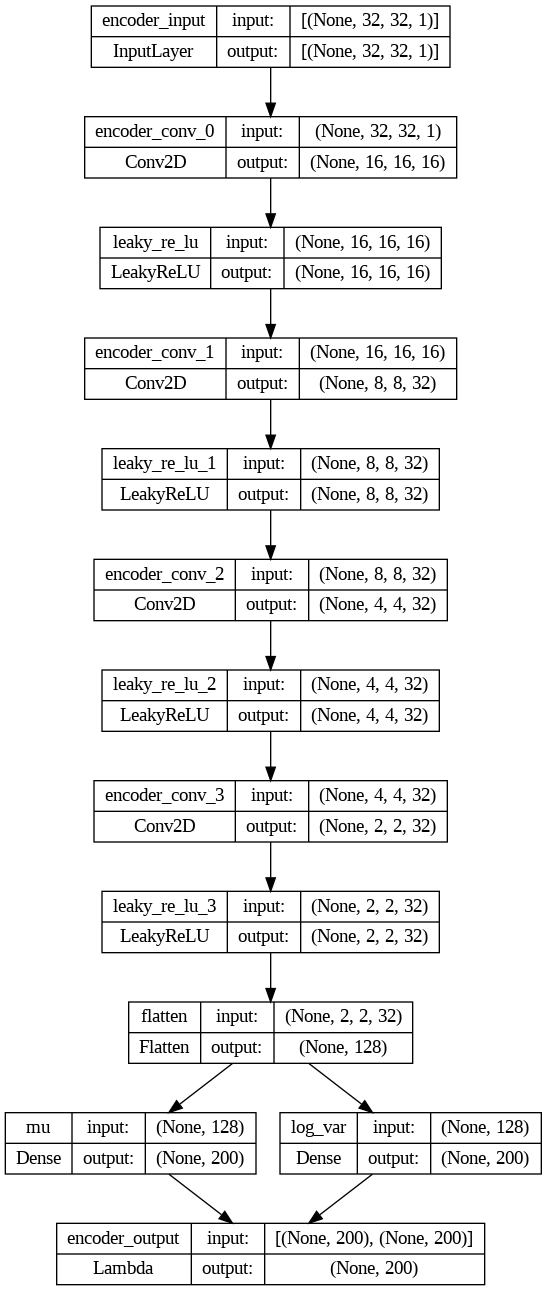

In [11]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

In [12]:
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 reshape (Reshape)           (None, 2, 2, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 4, 4, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 8, 8, 32)         9248      
 pose)                                                     

In [13]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                            

In [14]:
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [15]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

def calculate_fid(model, images1, images2):
    # Resize images to (299, 299, 3)
    images1_resized = resize(images1, (images1.shape[0], 299, 299, 3))
    images2_resized = resize(images2, (images2.shape[0], 299, 299, 3))
    
    # Preprocess images for the InceptionV3 model
    images1_preprocessed = preprocess_input(images1_resized)
    images2_preprocessed = preprocess_input(images2_resized)
    
    # Calculate activations
    act1 = model.predict(images1_preprocessed)
    act2 = model.predict(images2_preprocessed)
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    # Calculate square root of the product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Handle potential imaginary components from sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

Instructions for updating:
Colocations handled automatically by placer.


87910968/87910968 [==============================] - 1s 0us/step


Epoch 1/6
35/35 [==============================] - 29s 577ms/step - batch: 17.5000 - size: 64.0000 - loss: 861.0534 - r_loss: 0.0861 - kl_loss: 0.0577
Epoch 2/6
35/35 [==============================] - 5s 150ms/step - batch: 17.5000 - size: 64.0000 - loss: 780.9124 - r_loss: 0.0769 - kl_loss: 12.3976
Epoch 3/6
35/35 [==============================] - 5s 146ms/step - batch: 17.5000 - size: 64.0000 - loss: 579.5632 - r_loss: 0.0555 - kl_loss: 24.3861
Epoch 4/6
35/35 [==============================] - 5s 137ms/step - batch: 17.5000 - size: 64.0000 - loss: 461.7119 - r_loss: 0.0427 - kl_loss: 34.3176
Epoch 5/6
35/35 [==============================] - 6s 161ms/step - batch: 17.5000 - size: 63.5278 - loss: 410.7950 - r_loss: 0.0372 - kl_loss: 38.3438
Epoch 6/6
35/35 [==============================] - 5s 134ms/step - batch: 17.5000 - size: 64.0000 - loss: 383.3471 - r_loss: 0.0342 - kl_loss: 41.2254


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


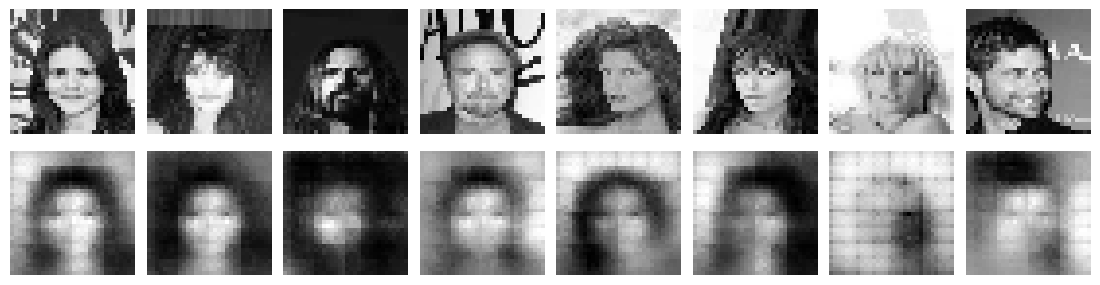

FID: 1.7377154427508748
Epoch 1/6
35/35 [==============================] - 6s 156ms/step - batch: 17.5000 - size: 64.0000 - loss: 369.1285 - r_loss: 0.0327 - kl_loss: 42.1707
Epoch 2/6
35/35 [==============================] - 6s 173ms/step - batch: 17.5000 - size: 64.0000 - loss: 350.5918 - r_loss: 0.0308 - kl_loss: 42.9072
Epoch 3/6
35/35 [==============================] - 5s 150ms/step - batch: 17.5000 - size: 64.0000 - loss: 348.4076 - r_loss: 0.0305 - kl_loss: 43.5679
Epoch 4/6
35/35 [==============================] - 6s 169ms/step - batch: 17.5000 - size: 64.0000 - loss: 339.3200 - r_loss: 0.0295 - kl_loss: 44.4536
Epoch 5/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 64.0000 - loss: 331.4367 - r_loss: 0.0288 - kl_loss: 43.6437
Epoch 6/6
35/35 [==============================] - 6s 165ms/step - batch: 17.5000 - size: 64.0000 - loss: 332.0595 - r_loss: 0.0286 - kl_loss: 45.5759


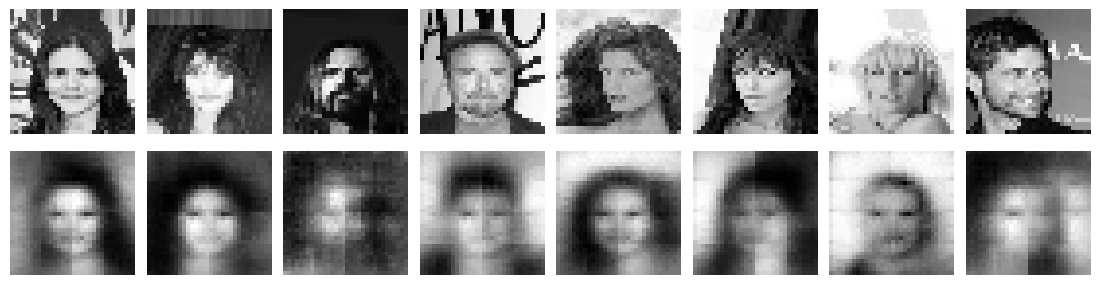

FID: 1.7078682272251244
Epoch 1/6
35/35 [==============================] - 5s 153ms/step - batch: 17.5000 - size: 64.0000 - loss: 323.1507 - r_loss: 0.0277 - kl_loss: 45.7954
Epoch 2/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 321.7930 - r_loss: 0.0275 - kl_loss: 46.3952
Epoch 3/6
35/35 [==============================] - 6s 156ms/step - batch: 17.5000 - size: 63.5278 - loss: 319.4435 - r_loss: 0.0273 - kl_loss: 46.6272
Epoch 4/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 314.0296 - r_loss: 0.0267 - kl_loss: 46.8374
Epoch 5/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 316.6330 - r_loss: 0.0269 - kl_loss: 47.8752
Epoch 6/6
35/35 [==============================] - 6s 156ms/step - batch: 17.5000 - size: 64.0000 - loss: 311.7029 - r_loss: 0.0263 - kl_loss: 48.3399


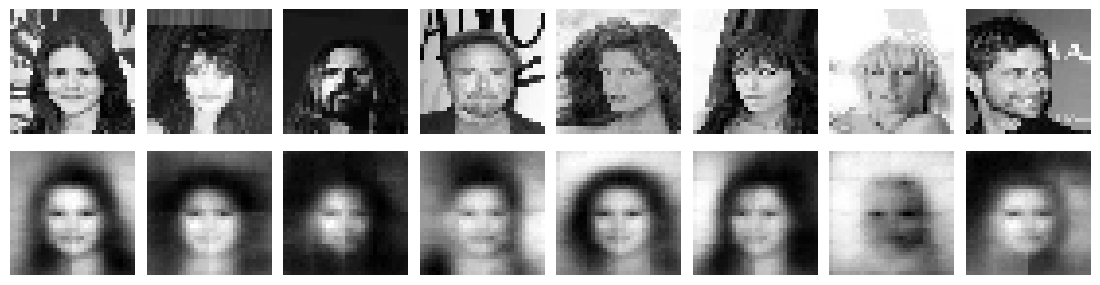

FID: 1.7510890647512816
Epoch 1/6
35/35 [==============================] - 5s 150ms/step - batch: 17.5000 - size: 64.0000 - loss: 307.7403 - r_loss: 0.0259 - kl_loss: 48.3221
Epoch 2/6
35/35 [==============================] - 5s 144ms/step - batch: 17.5000 - size: 64.0000 - loss: 303.4561 - r_loss: 0.0255 - kl_loss: 48.4900
Epoch 3/6
35/35 [==============================] - 6s 162ms/step - batch: 17.5000 - size: 64.0000 - loss: 305.2239 - r_loss: 0.0255 - kl_loss: 49.9380
Epoch 4/6
35/35 [==============================] - 5s 143ms/step - batch: 17.5000 - size: 64.0000 - loss: 305.1508 - r_loss: 0.0256 - kl_loss: 49.6472
Epoch 5/6
35/35 [==============================] - 5s 143ms/step - batch: 17.5000 - size: 64.0000 - loss: 301.3390 - r_loss: 0.0252 - kl_loss: 49.3015
Epoch 6/6
35/35 [==============================] - 7s 206ms/step - batch: 17.5000 - size: 64.0000 - loss: 291.9274 - r_loss: 0.0242 - kl_loss: 49.6348


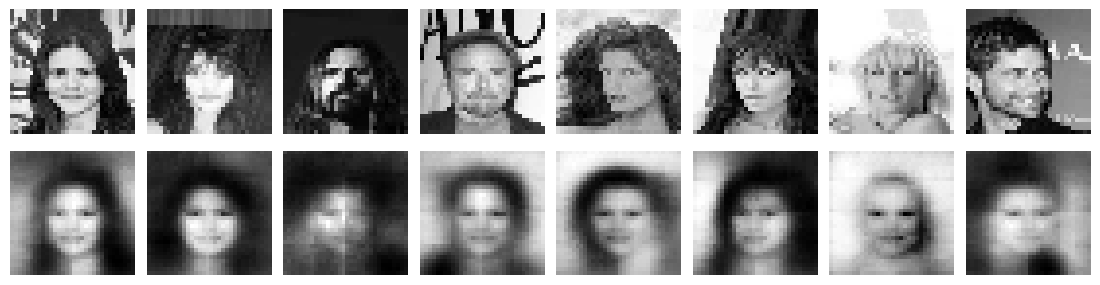

FID: 1.7408649302447934
Epoch 1/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 292.8519 - r_loss: 0.0243 - kl_loss: 49.8318
Epoch 2/6
35/35 [==============================] - 6s 156ms/step - batch: 17.5000 - size: 64.0000 - loss: 296.2602 - r_loss: 0.0247 - kl_loss: 49.6593
Epoch 3/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 293.9083 - r_loss: 0.0243 - kl_loss: 50.6210
Epoch 4/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 64.0000 - loss: 287.7616 - r_loss: 0.0238 - kl_loss: 49.4705
Epoch 5/6
35/35 [==============================] - 8s 229ms/step - batch: 17.5000 - size: 64.0000 - loss: 290.2531 - r_loss: 0.0240 - kl_loss: 49.7626
Epoch 6/6
35/35 [==============================] - 6s 162ms/step - batch: 17.5000 - size: 64.0000 - loss: 287.1202 - r_loss: 0.0238 - kl_loss: 49.3100


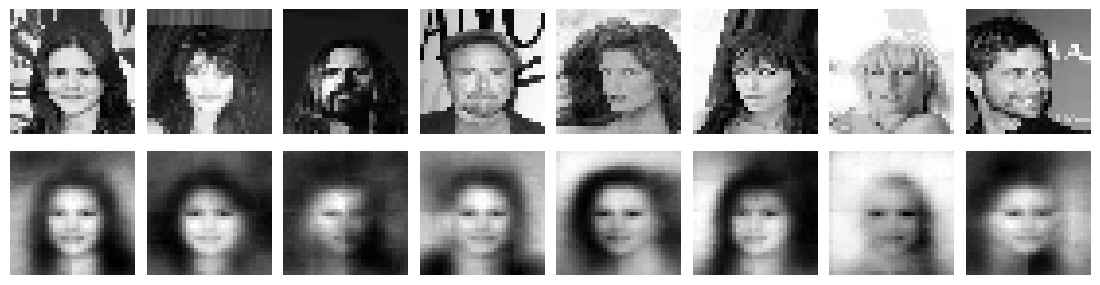

FID: 1.6416558376526356


In [ ]:
vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

for i in range(N_BLOCKS):
  vae.fit(data_flow, shuffle=True, epochs = N_EPOCHS, initial_epoch = 0, steps_per_epoch=(NUM_IMAGES / BATCH_SIZE) / 20)
    
  # Generate reconstructed images
  reconst_images = vae.predict(example_images)

  # Compute FID
  fid = calculate_fid(fid_model, example_images, reconst_images)

  # Plot and display images with FID
  plot_compare_VAE(example_images)
  print("FID:", fid)

## 3.2. Second

In [ ]:
z_dim = 100

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                              

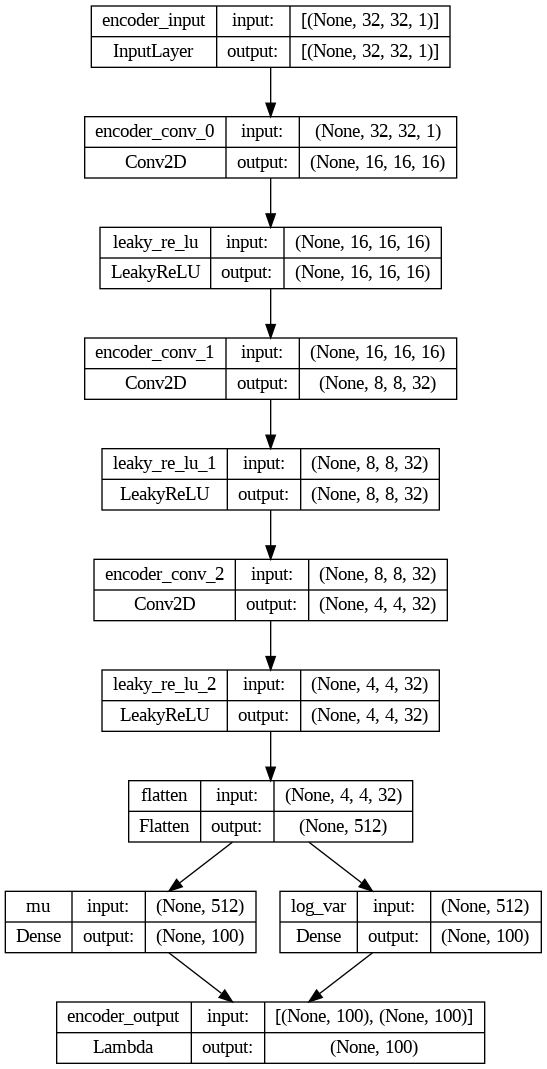

In [ ]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = z_dim, 
    conv_filters = [16, 32, 32],
    conv_kernel_size = [3,3,3],
    conv_strides = [2,2,2])

vae_encoder.summary()
plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

In [ ]:
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = z_dim,
    shape_before_flattening = vae_shape_before_flattening,     
    conv_filters = [32,16,1],
    conv_kernel_size = [3,3,3],
    conv_strides = [2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 reshape (Reshape)           (None, 4, 4, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 8, 8, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 16, 16, 16)       4624      
 pose)                                                     

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                            

In [ ]:
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

Epoch 1/6
35/35 [==============================] - 29s 613ms/step - batch: 17.5000 - size: 64.0000 - loss: 856.3423 - r_loss: 0.0856 - kl_loss: 0.3493
Epoch 2/6
35/35 [==============================] - 5s 149ms/step - batch: 17.5000 - size: 63.5278 - loss: 717.4228 - r_loss: 0.0692 - kl_loss: 26.0577
Epoch 3/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 462.8086 - r_loss: 0.0423 - kl_loss: 39.3202
Epoch 4/6
35/35 [==============================] - 5s 150ms/step - batch: 17.5000 - size: 64.0000 - loss: 381.6764 - r_loss: 0.0340 - kl_loss: 42.0935
Epoch 5/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 353.3090 - r_loss: 0.0310 - kl_loss: 43.2678
Epoch 6/6
35/35 [==============================] - 5s 151ms/step - batch: 17.5000 - size: 64.0000 - loss: 334.0097 - r_loss: 0.0288 - kl_loss: 45.5716


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


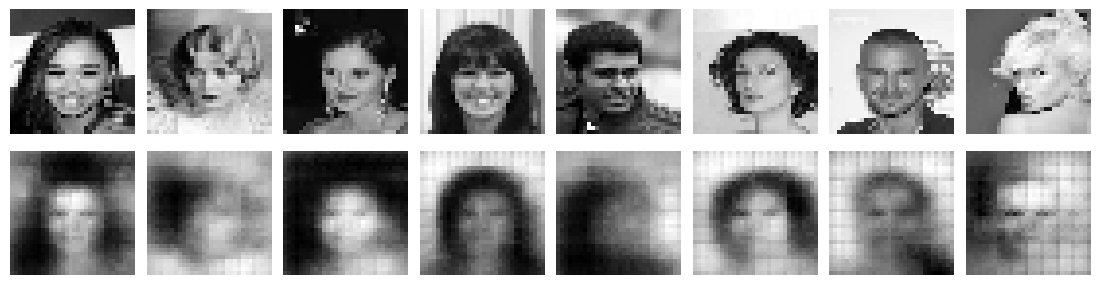

FID: 1.453655083033519
Epoch 1/6
35/35 [==============================] - 6s 155ms/step - batch: 17.5000 - size: 64.0000 - loss: 319.4391 - r_loss: 0.0273 - kl_loss: 46.5280
Epoch 2/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 309.5852 - r_loss: 0.0262 - kl_loss: 47.6163
Epoch 3/6
35/35 [==============================] - 7s 195ms/step - batch: 17.5000 - size: 64.0000 - loss: 305.8003 - r_loss: 0.0257 - kl_loss: 49.2613
Epoch 4/6
35/35 [==============================] - 5s 143ms/step - batch: 17.5000 - size: 64.0000 - loss: 297.9075 - r_loss: 0.0247 - kl_loss: 51.0887
Epoch 5/6
35/35 [==============================] - 5s 134ms/step - batch: 17.5000 - size: 63.5278 - loss: 290.9248 - r_loss: 0.0240 - kl_loss: 50.7349
Epoch 6/6
35/35 [==============================] - 5s 151ms/step - batch: 17.5000 - size: 64.0000 - loss: 288.3335 - r_loss: 0.0236 - kl_loss: 51.9690


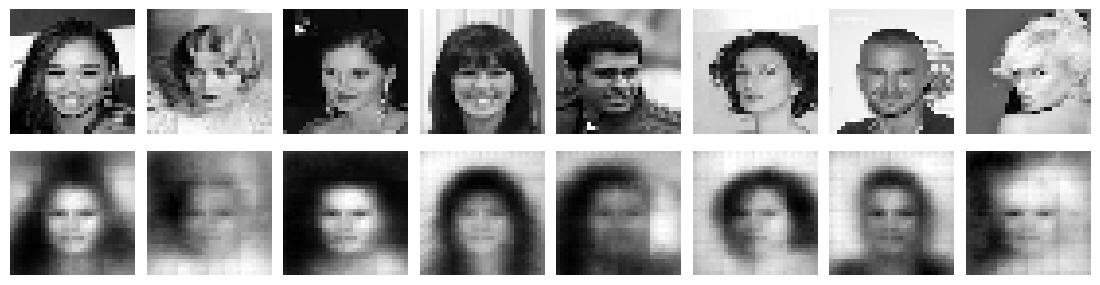

FID: 1.3128758003406882
Epoch 1/6
35/35 [==============================] - 6s 160ms/step - batch: 17.5000 - size: 64.0000 - loss: 283.8519 - r_loss: 0.0232 - kl_loss: 52.1262
Epoch 2/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 275.5336 - r_loss: 0.0224 - kl_loss: 52.0077
Epoch 3/6
35/35 [==============================] - 5s 154ms/step - batch: 17.5000 - size: 64.0000 - loss: 275.2869 - r_loss: 0.0222 - kl_loss: 52.9958
Epoch 4/6
35/35 [==============================] - 5s 135ms/step - batch: 17.5000 - size: 64.0000 - loss: 272.0893 - r_loss: 0.0219 - kl_loss: 53.3139
Epoch 5/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 64.0000 - loss: 269.9432 - r_loss: 0.0216 - kl_loss: 53.7804
Epoch 6/6
35/35 [==============================] - 5s 152ms/step - batch: 17.5000 - size: 64.0000 - loss: 269.9166 - r_loss: 0.0216 - kl_loss: 53.6931


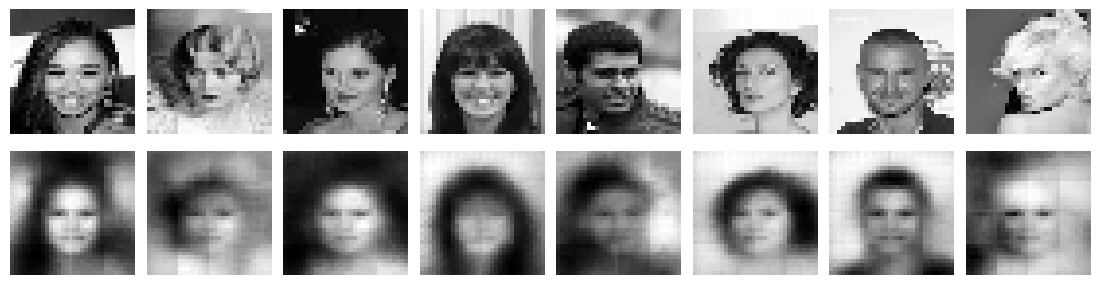

FID: 1.3386094785527163
Epoch 1/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 264.3706 - r_loss: 0.0211 - kl_loss: 53.5897
Epoch 2/6
35/35 [==============================] - 5s 135ms/step - batch: 17.5000 - size: 64.0000 - loss: 260.4997 - r_loss: 0.0207 - kl_loss: 53.3302
Epoch 3/6
35/35 [==============================] - 6s 158ms/step - batch: 17.5000 - size: 64.0000 - loss: 257.8182 - r_loss: 0.0205 - kl_loss: 53.2222
Epoch 4/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 258.3732 - r_loss: 0.0204 - kl_loss: 54.0793
Epoch 5/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 63.5278 - loss: 253.0494 - r_loss: 0.0200 - kl_loss: 53.5378
Epoch 6/6
35/35 [==============================] - 5s 152ms/step - batch: 17.5000 - size: 64.0000 - loss: 253.0034 - r_loss: 0.0199 - kl_loss: 53.7317


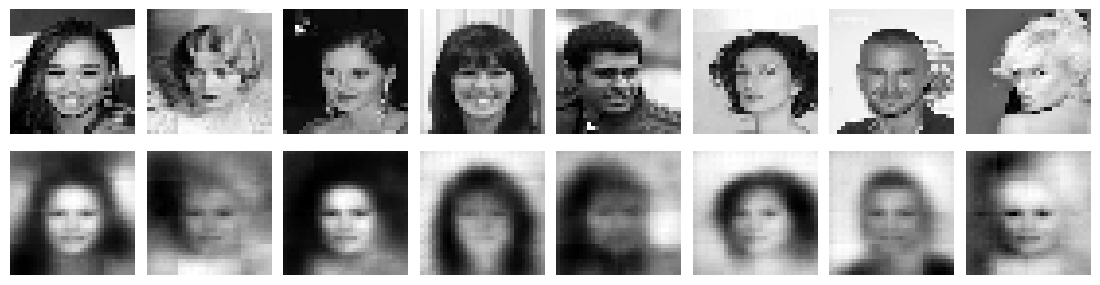

FID: 1.299848899089862
Epoch 1/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 254.0789 - r_loss: 0.0200 - kl_loss: 53.9737
Epoch 2/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 249.9193 - r_loss: 0.0197 - kl_loss: 53.1663
Epoch 3/6
35/35 [==============================] - 6s 157ms/step - batch: 17.5000 - size: 64.0000 - loss: 247.5190 - r_loss: 0.0194 - kl_loss: 53.3774
Epoch 4/6
35/35 [==============================] - 5s 135ms/step - batch: 17.5000 - size: 64.0000 - loss: 246.5379 - r_loss: 0.0193 - kl_loss: 53.1409
Epoch 5/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 63.5278 - loss: 244.7126 - r_loss: 0.0192 - kl_loss: 53.1972
Epoch 6/6
35/35 [==============================] - 6s 154ms/step - batch: 17.5000 - size: 64.0000 - loss: 243.1529 - r_loss: 0.0190 - kl_loss: 52.7103


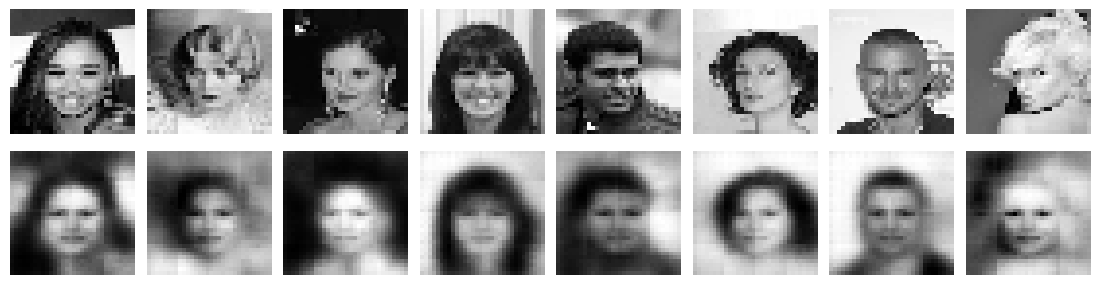

FID: 1.2703076006598057


In [ ]:
vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

for i in range(N_BLOCKS):
  vae.fit(data_flow, 
      shuffle=True, 
      epochs = N_EPOCHS, 
      initial_epoch = 0, 
      steps_per_epoch=(NUM_IMAGES / BATCH_SIZE) / 20)
  
  # Generate reconstructed images
  reconst_images = vae.predict(example_images)

  # Compute FID
  fid = calculate_fid(fid_model, example_images, reconst_images)

  # Plot and display images with FID
  plot_compare_VAE(example_images)
  print("FID:", fid)

## 3.3. Third

In [ ]:
Z_DIM = 100

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                              

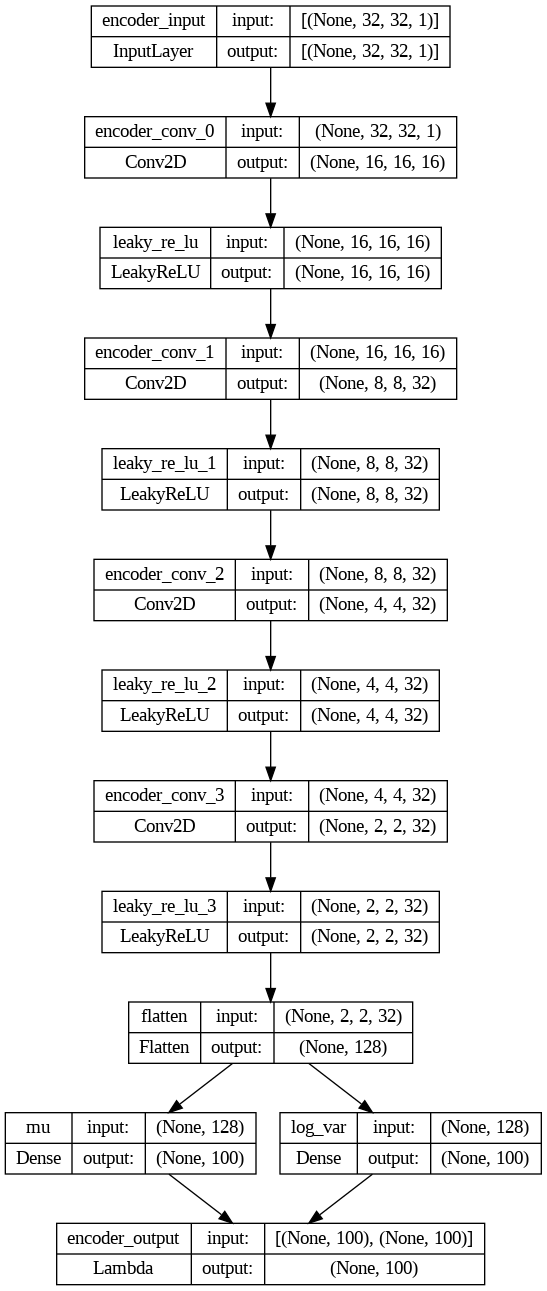

In [ ]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

In [ ]:
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 reshape (Reshape)           (None, 2, 2, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 4, 4, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 8, 8, 32)         9248      
 pose)                                                     

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                            

Epoch 1/6
35/35 [==============================] - 4s 98ms/step - batch: 17.5000 - size: 64.0000 - loss: 362.2490 - r_loss: 0.0320 - kl_loss: 41.7570
Epoch 2/6
35/35 [==============================] - 5s 152ms/step - batch: 17.5000 - size: 64.0000 - loss: 357.2970 - r_loss: 0.0314 - kl_loss: 43.6465
Epoch 3/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 345.3815 - r_loss: 0.0303 - kl_loss: 42.7223
Epoch 4/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 64.0000 - loss: 334.4781 - r_loss: 0.0290 - kl_loss: 44.5237
Epoch 5/6
35/35 [==============================] - 6s 156ms/step - batch: 17.5000 - size: 64.0000 - loss: 328.2411 - r_loss: 0.0283 - kl_loss: 44.9398
Epoch 6/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 325.6175 - r_loss: 0.0280 - kl_loss: 45.1370


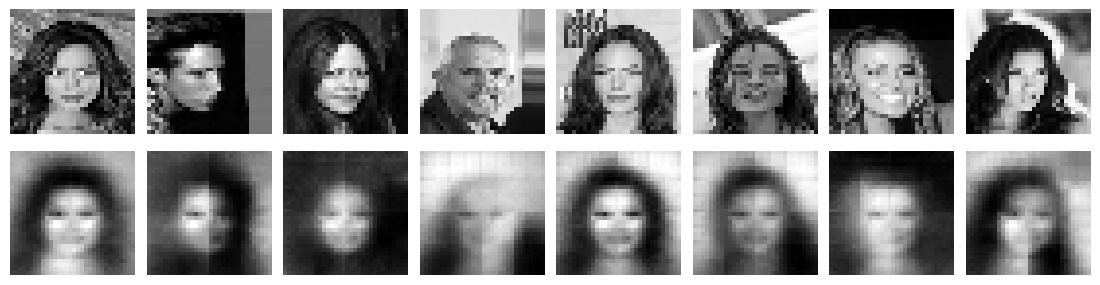

FID: 1.6578703413506684
Epoch 1/6
35/35 [==============================] - 5s 149ms/step - batch: 17.5000 - size: 64.0000 - loss: 318.5821 - r_loss: 0.0272 - kl_loss: 46.0978
Epoch 2/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 318.4296 - r_loss: 0.0272 - kl_loss: 46.1496
Epoch 3/6
35/35 [==============================] - 5s 140ms/step - batch: 17.5000 - size: 64.0000 - loss: 314.1242 - r_loss: 0.0267 - kl_loss: 47.1037
Epoch 4/6
35/35 [==============================] - 5s 154ms/step - batch: 17.5000 - size: 64.0000 - loss: 304.6984 - r_loss: 0.0258 - kl_loss: 46.3950
Epoch 5/6
35/35 [==============================] - 5s 137ms/step - batch: 17.5000 - size: 64.0000 - loss: 304.7958 - r_loss: 0.0257 - kl_loss: 47.5041
Epoch 6/6
35/35 [==============================] - 5s 154ms/step - batch: 17.5000 - size: 64.0000 - loss: 303.1525 - r_loss: 0.0256 - kl_loss: 47.4372


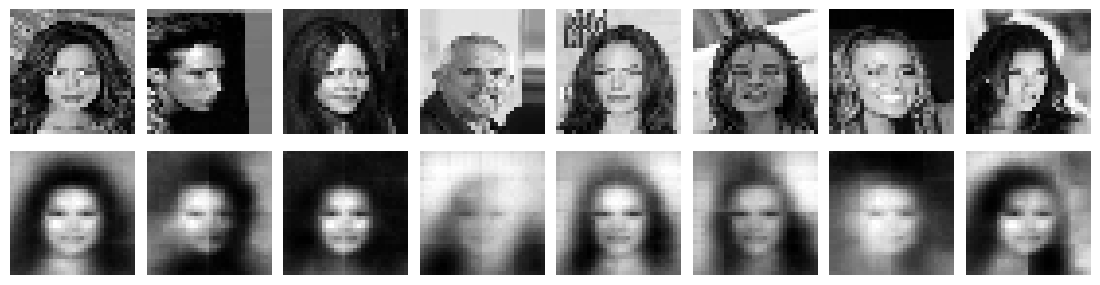

FID: 1.606396570397679
Epoch 1/6
35/35 [==============================] - 6s 159ms/step - batch: 17.5000 - size: 64.0000 - loss: 297.0365 - r_loss: 0.0250 - kl_loss: 47.3219
Epoch 2/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 293.6271 - r_loss: 0.0246 - kl_loss: 47.2755
Epoch 3/6
35/35 [==============================] - 5s 141ms/step - batch: 17.5000 - size: 64.0000 - loss: 294.0075 - r_loss: 0.0246 - kl_loss: 47.7250
Epoch 4/6
35/35 [==============================] - 6s 154ms/step - batch: 17.5000 - size: 64.0000 - loss: 286.8001 - r_loss: 0.0239 - kl_loss: 47.8791
Epoch 5/6
35/35 [==============================] - 5s 137ms/step - batch: 17.5000 - size: 64.0000 - loss: 290.3984 - r_loss: 0.0243 - kl_loss: 47.7386
Epoch 6/6
35/35 [==============================] - 5s 148ms/step - batch: 17.5000 - size: 64.0000 - loss: 282.9144 - r_loss: 0.0236 - kl_loss: 47.1681


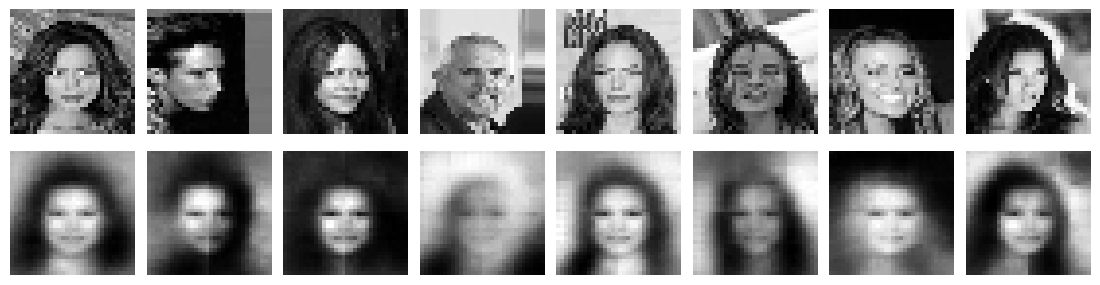

FID: 1.5665470312001641
Epoch 1/6
35/35 [==============================] - 6s 157ms/step - batch: 17.5000 - size: 64.0000 - loss: 282.2762 - r_loss: 0.0235 - kl_loss: 47.4770
Epoch 2/6
35/35 [==============================] - 5s 138ms/step - batch: 17.5000 - size: 64.0000 - loss: 279.9378 - r_loss: 0.0232 - kl_loss: 47.5563
Epoch 3/6
35/35 [==============================] - 5s 140ms/step - batch: 17.5000 - size: 64.0000 - loss: 276.5227 - r_loss: 0.0229 - kl_loss: 47.6589
Epoch 4/6
35/35 [==============================] - 5s 149ms/step - batch: 17.5000 - size: 64.0000 - loss: 279.2193 - r_loss: 0.0232 - kl_loss: 47.5579
Epoch 5/6
35/35 [==============================] - 5s 139ms/step - batch: 17.5000 - size: 64.0000 - loss: 269.9628 - r_loss: 0.0223 - kl_loss: 47.1408
Epoch 6/6
35/35 [==============================] - 5s 146ms/step - batch: 17.5000 - size: 63.5278 - loss: 270.5570 - r_loss: 0.0224 - kl_loss: 46.8561


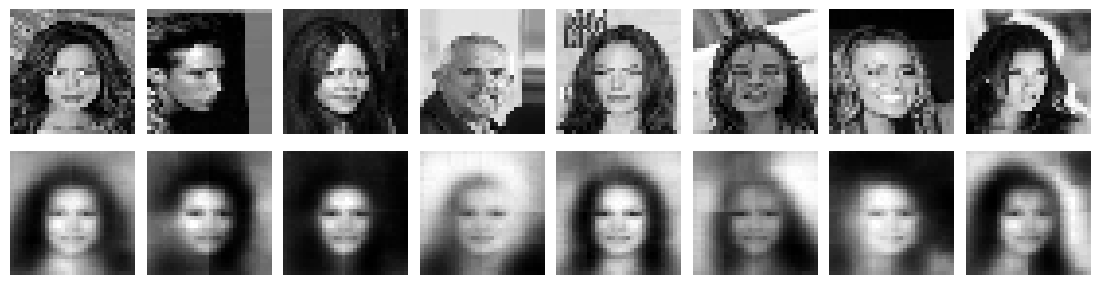

FID: 1.584272867157118
Epoch 1/6
35/35 [==============================] - 6s 155ms/step - batch: 17.5000 - size: 64.0000 - loss: 266.6602 - r_loss: 0.0219 - kl_loss: 47.2006
Epoch 2/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 270.5073 - r_loss: 0.0223 - kl_loss: 47.4283
Epoch 3/6
35/35 [==============================] - 6s 165ms/step - batch: 17.5000 - size: 64.0000 - loss: 269.5952 - r_loss: 0.0223 - kl_loss: 46.9340
Epoch 4/6
35/35 [==============================] - 6s 162ms/step - batch: 17.5000 - size: 64.0000 - loss: 263.2198 - r_loss: 0.0217 - kl_loss: 46.4396
Epoch 5/6
35/35 [==============================] - 5s 136ms/step - batch: 17.5000 - size: 64.0000 - loss: 261.1989 - r_loss: 0.0215 - kl_loss: 46.5964
Epoch 6/6
35/35 [==============================] - 5s 149ms/step - batch: 17.5000 - size: 64.0000 - loss: 263.9870 - r_loss: 0.0217 - kl_loss: 46.5289


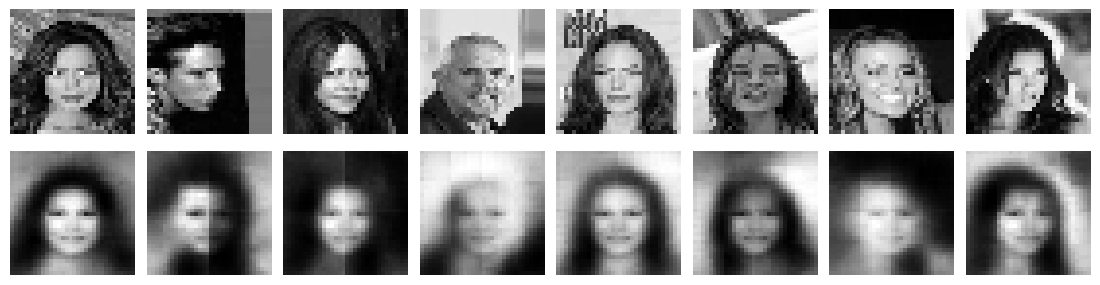

FID: 1.5937108917980276


In [ ]:
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

for i in range(N_BLOCKS):
  vae.fit(data_flow, 
      shuffle=True, 
      epochs = N_EPOCHS, 
      initial_epoch = 0, 
      steps_per_epoch=(NUM_IMAGES / BATCH_SIZE) / 20)
  
  # Generate reconstructed images
  reconst_images = vae.predict(example_images)

  # Compute FID
  fid = calculate_fid(fid_model, example_images, reconst_images)

  # Plot and display images with FID
  plot_compare_VAE(example_images)
  print("FID:", fid)

# Interpolation

In [32]:
import numpy as np
from scipy.stats import norm

def interpolate_images_vae(vae_encoder, vae_decoder, image1, image2, n=8):
    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)

    # Encode the images into the latent space
    z1 = vae_encoder.predict(image1)
    z2 = vae_encoder.predict(image2)
    
    # Create a range of values to interpolate between the two encoded images
    z_range = np.linspace(norm.ppf(0.05), norm.ppf(0.95), n)
    
    # Interpolate between the two encoded images
    z_interp = np.array([z1 + (z2 - z1) * t for t in z_range])

    z_interp = np.squeeze(z_interp, axis=1)

    
    # Decode the interpolated values back into images
    interp_images = vae_decoder.predict(z_interp)
    
    return interp_images


In [61]:
interp_images = interpolate_images_vae(vae_encoder,vae_decoder, example_images[0], example_images[1])


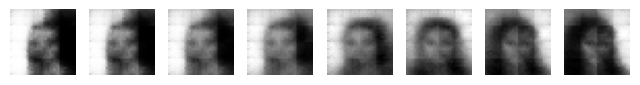

In [64]:
import matplotlib.pyplot as plt

def show_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

show_images(interp_images)
